# Homework 0. Tinkoff education DL cource.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Function for downloading MNIST
def get_loader(train, batch_size):
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 128)
val = get_loader(False, 128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Task 0: Mnist images classification.

In [ ]:
# Model architecture.
# Was found with blood, sweat, and loss of free GPU.
'''model = nn.Sequential( # This one works very good.
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)'''

model = nn.Sequential( # A lot of chaotic affairs.
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(256, 128),
    #nn.ReLU(),
    #nn.Dropout(p=0.2),
    #n.Linear(100, 25),
    #nn.ReLU(),
    #nn.Linear(25, 25),
    nn.Dropout(p=0.25),
    nn.Linear(128, 10),
    #nn.ReLU(),
    #nn.Dropout(p=0.2),
    nn.LogSoftmax(dim=1)
)

In [4]:
def accuracy(model, val):
    model.eval() # To turn off Dropout during evaluation.
    total = 0
    correct = 0
    for X, y in val:
        # y = y.cuda() # uncomment for gpu usage.
        # X = X.cuda()
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [ ]:
# model = model.cuda() # Uncomment for gpu usage.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

In [ ]:
train_losses = []
train_accuracy = []
test_accuracy = []

0 0.95615 0.9529
1 0.9729833333333333 0.9684
2 0.9818333333333333 0.9757
3 0.9856333333333334 0.9766
4 0.9885333333333334 0.9785
5 0.9912666666666666 0.979
6 0.9928166666666667 0.9805
7 0.99305 0.9785
8 0.9948833333333333 0.9799
9 0.9958833333333333 0.9817
10 0.9953833333333333 0.9808
11 0.9956333333333334 0.9837
12 0.9959333333333333 0.9817
13 0.9966166666666667 0.9816
14 0.99655 0.9796
15 0.9970333333333333 0.9814
16 0.9976833333333334 0.9815
17 0.9978833333333333 0.9817
18 0.9968833333333333 0.9804
19 0.9982 0.9802


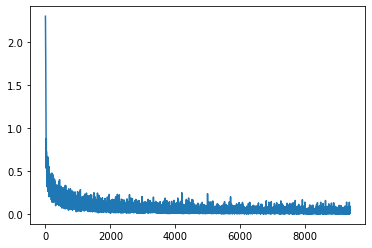

In [ ]:
# Training process.
for epoch in range(20):
    model.train() # Turn on Dropout.
    for X, y in train:
        #X = X.cuda() # For gpu usage.
        #y = y.cuda()
        X = X.view(-1, 784)
        
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        train_losses.append(loss.item()) # Puts copy instead of link.
        optimizer.step()
    
    train_accuracy.append(accuracy(model, train))
    test_accuracy.append(accuracy(model, val))
    print(epoch, train_accuracy[-1], test_accuracy[-1])
    

plt.plot(train_losses)
plt.show()

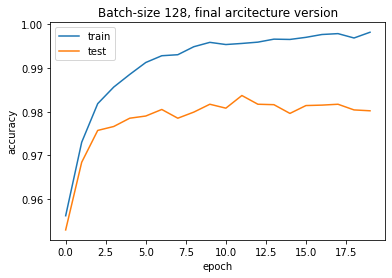

In [ ]:
plt.plot([i for i in range(20)], train_accuracy, test_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(('train','test'))
plt.title("Batch-size 128, final arcitecture version")
plt.show()


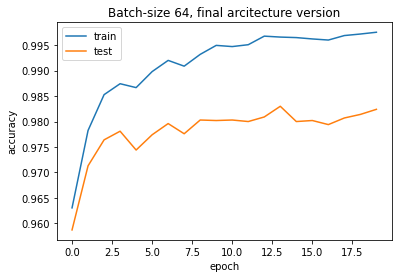

Модель дает результат больше 0.975 даже при batch_size = 64, при увеличении этого значения значения точности на тестовой выборке менее скачкообразны.

## Task 2. Mnist morphing.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 15)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(15, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Training of autoencoder.
for epoch in range(20):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0491
epoch 1, loss 0.0230
epoch 2, loss 0.0191
epoch 3, loss 0.0177
epoch 4, loss 0.0167
epoch 5, loss 0.0161
epoch 6, loss 0.0155
epoch 7, loss 0.0151
epoch 8, loss 0.0147
epoch 9, loss 0.0144
epoch 10, loss 0.0141
epoch 11, loss 0.0138
epoch 12, loss 0.0136
epoch 13, loss 0.0134
epoch 14, loss 0.0132
epoch 15, loss 0.0131
epoch 16, loss 0.0129
epoch 17, loss 0.0128
epoch 18, loss 0.0127
epoch 19, loss 0.0125


In [ ]:
# Gif Generation
from matplotlib import animation
import numpy
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [ ]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

[57425 14770 36822 49050 22073  2277  6319 27013 37147 57855 34175  5457
 43654 49924 58490 11442 41585  1115  4282 59318 39949 55319 24172 16639
 28871 27131 49130 22059 28447 11808]


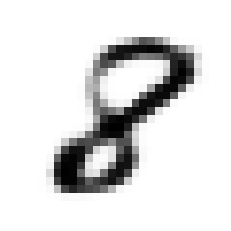

In [ ]:
inputs = numpy.random.randint(0, len(train.dataset), 30)
morph(inputs, 25, 30)
print(inputs)

## Task 3.Mnist visualisation.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Training of autoencoder.
for epoch in range(20):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.1404
epoch 1, loss 0.1120
epoch 2, loss 0.1065
epoch 3, loss 0.1031
epoch 4, loss 0.1006
epoch 5, loss 0.0988
epoch 6, loss 0.0975
epoch 7, loss 0.0966
epoch 8, loss 0.0956
epoch 9, loss 0.0950
epoch 10, loss 0.0942
epoch 11, loss 0.0937
epoch 12, loss 0.0932
epoch 13, loss 0.0929
epoch 14, loss 0.0924
epoch 15, loss 0.0920
epoch 16, loss 0.0918
epoch 17, loss 0.0914
epoch 18, loss 0.0910
epoch 19, loss 0.0905


In [ ]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm

In [ ]:
numbers = [[[] for i in range(2)] for i in range(10)]
for X, y in train.dataset:
    array = model.encode(X.view(-1,784)).detach().numpy()
    numbers[y][0].append(array[0][0])
    numbers[y][1].append(array[0][1])


In [ ]:
handles = []
plt.figure(figsize=(10, 10), dpi=50)
colormap = cm.rainbow(numpy.linspace(0, 1, len(digits)))
for y, c in zip(numpy.arange(0, 11, 1), colormap):
    handles.append(mpatches.Patch(color=c, label=y))
    plt.scatter(numbers[y][0], numbers[y][1], color=c)
plt.legend(handles=handles)

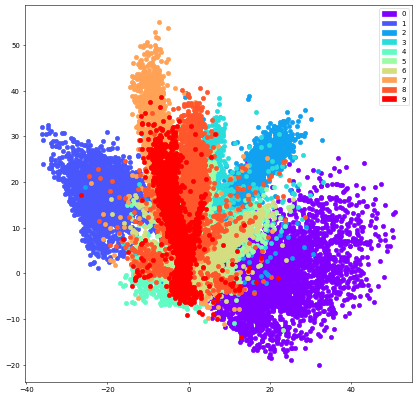

## Task nan. Try to make more accurate classification.

In [14]:
class ConvolutionalNN(nn.Module):
    def __init__(self): # 28*28 -> 24*24 -> 12*12 -> 8*8 -> 4*4
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=25, kernel_size=5)
      # self.conv3 = nn.Conv2d(in_channels=16, out_channels=25, kernel_size=3)
      self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
      self.fc1 = nn.Linear(4 * 4 * 25, 128)
      self.fc2 = nn.Linear(128, 64)
      self.fc3 = nn.Linear(64, 10)
      self.lsm = nn.LogSoftmax()
    
    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = F.dropout(x, p=0.3)
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 4 * 4 * 25)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, p=0.3)
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      x = self.lsm(x)
      return x

In [18]:
def accuracy(model, val):
    model.eval() # To turn off Dropout during evaluation.
    total = 0
    correct = 0
    for X, y in val:
        # y = y.cuda() # uncomment for gpu usage.
        # X = X.cuda()
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [15]:
# model = model.cuda() # Uncomment for gpu usage.
model = ConvolutionalNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

In [16]:
train_losses = []
train_accuracy = []
test_accuracy = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0 0.97075 0.9735
1 0.977 0.9773
2 0.9806333333333334 0.9797
3 0.9805 0.9796
4 0.9864 0.982
5 0.9874 0.9862
6 0.98795 0.9845
7 0.9886833333333334 0.9864
8 0.9907333333333334 0.988
9 0.9876333333333334 0.9851
10 0.9910333333333333 0.9884
11 0.9917333333333334 0.9876
12 0.9914666666666667 0.9883
13 0.9921333333333333 0.9882
14 0.9917166666666667 0.9885
15 0.9928 0.9874
16 0.9933833333333333 0.9883
17 0.9940166666666667 0.9902
18 0.99255 0.9879
19 0.994 0.9876
20 0.9941833333333333 0.9903
21 0.9938 0.9873
22 0.9941 0.9877
23 0.99325 0.9868
24 0.9936166666666667 0.9871
25 0.9946833333333334 0.9896
26 0.9937333333333334 0.9882
27 0.9950333333333333 0.9877
28 0.9950166666666667 0.9897
29 0.9952833333333333 0.9907


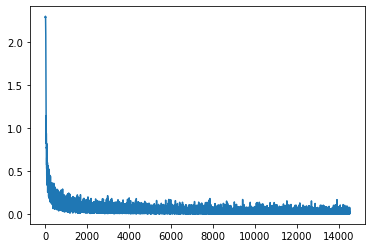

In [19]:
# Training process.
for epoch in range(30):
    model.train() # Turn on Dropout.
    for X, y in train:
        #X = X.cuda() # For gpu usage.
        #y = y.cuda()

        optimizer.zero_grad()
        
        output = model.forward(X)
        loss = criterion(output, y)
        loss.backward()
        train_losses.append(loss.item()) # Puts copy instead of link.
        optimizer.step()
    
    train_accuracy.append(accuracy(model, train))
    test_accuracy.append(accuracy(model, val))
    print(epoch, train_accuracy[-1], test_accuracy[-1])
    

plt.plot(train_losses)
plt.show()

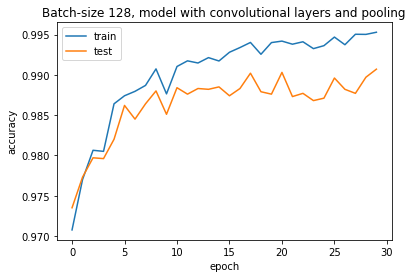

In [21]:
plt.plot([i for i in range(30)], train_accuracy, test_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(('train','test'))
plt.title("Batch-size 128, model with convolutional layers and pooling")
plt.show()
